Алгоритм "водораздел" используется для разделения (сегментации) изображения на различные объекты, особенно когда они соприкасаются друг с другом. Представьте себе черно-белое изображение как топографическую карту: светлые области — это вершины, а темные — долины. Если начать "заливать" каждую долину водой разного цвета, вода из соседних долин в какой-то момент начнет сливаться. Чтобы этого избежать, на местах слияния строят "плотины". Продолжая процесс, пока вся поверхность не будет покрыта водой, получаем разделение изображения на области, ограниченные этими плотинами. Это и есть принцип работы алгоритма водораздела.

В OpenCV реализован метод водораздела, где пользователь заранее отмечает известные области фона и объектов на изображении. Затем алгоритм, используя эти метки, определяет границы между объектами. Для этого:

Преобразуют изображение в оттенки серого и применяют пороговую обработку для выделения объектов.

Удаляют мелкие шумы с помощью морфологических операций (например, открытия и закрытия).

Определяют области, которые с высокой вероятностью являются фоном (расширение) и передним планом (эрозия или дистанционное преобразование).

Обозначают неуверенные области как "неизвестные".

Применяют алгоритм водораздела, который, основываясь на этих метках, разделяет изображение на различные объекты.

В результате границы между объектами отмечаются, что позволяет точно сегментировать изображение.


In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

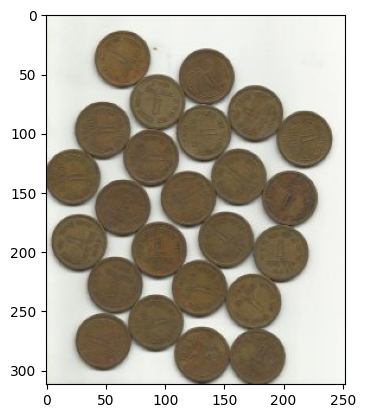

In [5]:
img = cv.imread(
    '../../image4labs/water_coins.jpg')[..., ::-1]
assert img is not None, "file could not be read, check with os.path.exists()"
plt.imshow(img)

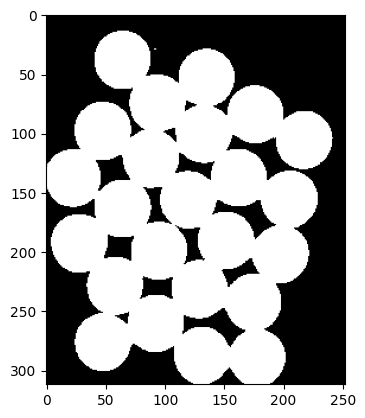

In [7]:
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
plt.imshow(thresh, cmap='grey')

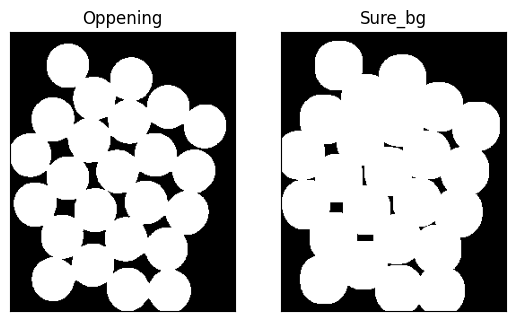

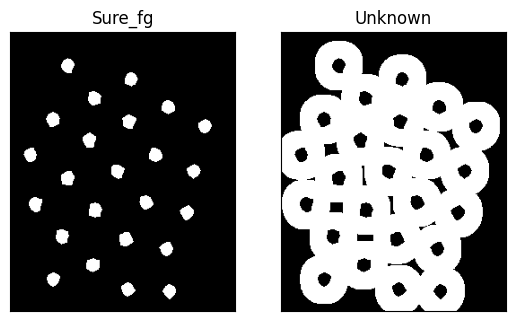

In [8]:
# noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=2)
# sure background area
sure_bg = cv.dilate(opening, kernel, iterations=3)
plt.subplot(121), plt.imshow(opening, cmap='gray')
plt.title('Oppening'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(sure_bg, cmap='gray')
plt.title('Sure_bg'), plt.xticks([]), plt.yticks([])
plt.show()
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
ret, sure_fg = cv.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg, sure_fg)
plt.subplot(121), plt.imshow(sure_fg, cmap='gray')
plt.title('Sure_fg'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(unknown, cmap='gray')
plt.title('Unknown'), plt.xticks([]), plt.yticks([])
plt.show()

Темно-синяя область показывает неизвестную область. Уверенные монеты окрашены разными значениями. Оставшаяся область, которая является уверенным фоном, показана более светло-синим цветом по сравнению с неизвестной областью.


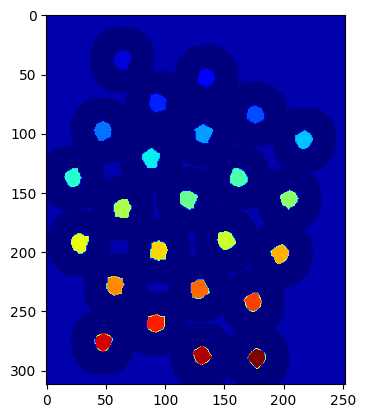

In [10]:
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown == 255] = 0
plt.imshow(markers, cmap='jet')

Теперь наш маркер готов. Пришло время для последнего шага, применить водораздел. Затем изображение маркера будет изменено. Граничная область будет отмечена как -1.


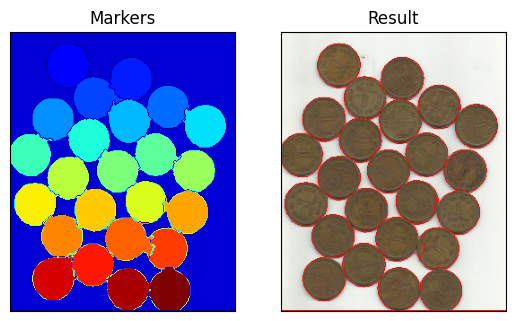

In [14]:
markers = cv.watershed(img, markers)
img[markers == -1] = [255, 0, 0]
plt.subplot(121), plt.imshow(markers, cmap='jet')
plt.title('Markers'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img, cmap='gray')
plt.title('Result'), plt.xticks([]), plt.yticks([])
plt.show()